In [2]:
import numpy as np
import matplotlib . pyplot as plt
import numpy as np
from sklearn . datasets import make_blobs
# Generate synthetic data
np. random . seed (0)
centers = [[ -5 , 0], [5, 1.5]]
X, y = make_blobs ( n_samples =2000 , centers = centers , random_state =5)
transformation = [[0.5 , 0.5] , [ -0.5 , 1.5]]
X = np. dot (X, transformation )

2. Batch Gradient descent

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Add bias term
N, D = X.shape
Xb = np.hstack([np.ones((N, 1)), X])  # shape: (N, D+1)


#Logistic regression via GD

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_loss(w, Xb, y):
    z = Xb @ w
    p = sigmoid(z)
    eps = 1e-12
    # Binary cross-entropy (negative log-likelihood)
    return -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))

def accuracy(w, Xb, y):
    p = sigmoid(Xb @ w)
    yhat = (p >= 0.5).astype(int)
    return (yhat == y).mean()

# Initialization: zeros (convex problem -> safe & stable)
w = np.zeros(D + 1)

# Hyperparameters
alpha = 0.1         # learning rate (works well with standardized features)
num_iters = 20

# GD loop
for t in range(1, num_iters + 1):
    p = sigmoid(Xb @ w)                       # (N,)
    grad = (Xb.T @ (p - y)) / N               # (D+1,)
    w = w - alpha * grad

    if t in (1, 5, 10, 20):
        L = logistic_loss(w, Xb, y)
        acc = accuracy(w, Xb, y)
        gnorm = np.linalg.norm(grad)
        print(f"iter {t:2d}: loss={L:.4f}, acc={acc:.4f}, ||grad||={gnorm:.4f}")

print("Final weights:", w)

iter  1: loss=0.6507, acc=1.0000, ||grad||=0.6593
iter  5: loss=0.5150, acc=1.0000, ||grad||=0.5487
iter 10: loss=0.4006, acc=1.0000, ||grad||=0.4426
iter 20: loss=0.2705, acc=1.0000, ||grad||=0.3082
Final weights: [1.41620804e-04 6.54453296e-01 6.24226485e-01]


Newtons Method

In [4]:

# Newton's method

w = np.zeros(D + 1)     # init at zero (safe for convex problem)
num_iters = 20
damping = 1e-6          # Tikhonov damping for numerical stability

for t in range(1, num_iters + 1):
    z = Xb @ w                       # (N,)
    p = sigmoid(z)                   # (N,)
    # Gradient: (D+1,)
    g = (Xb.T @ (p - y)) / N
    # Hessian: (D+1, D+1)  with S = diag(p*(1-p))
    s = p * (1.0 - p)                # (N,)
    # Form H = X^T S X / N without building full diagonal matrix
    XS = Xb * s[:, None]             # each row of Xb scaled by s_i
    H = (Xb.T @ XS) / N
    # Damped Newton step: solve H * delta = g
    H_damped = H + damping * np.eye(H.shape[0])
    delta = np.linalg.solve(H_damped, g)
    w = w - delta

    if t in (1, 5, 10, 20):
        L = logistic_loss(w, Xb, y)
        acc = accuracy(w, Xb, y)
        ngrad = np.linalg.norm(g)
        print(f"iter {t:2d}: loss={L:.6f}, acc={acc:.4f}, ||grad||={ngrad:.4e}")

print("Final weights:", w)

iter  1: loss=0.145220, acc=1.0000, ||grad||=6.5926e-01
iter  5: loss=0.003204, acc=1.0000, ||grad||=8.2254e-03
iter 10: loss=0.000041, acc=1.0000, ||grad||=6.6187e-05
iter 20: loss=0.000001, acc=1.0000, ||grad||=3.3465e-07
Final weights: [-0.94558762 14.81422766 10.91624081]


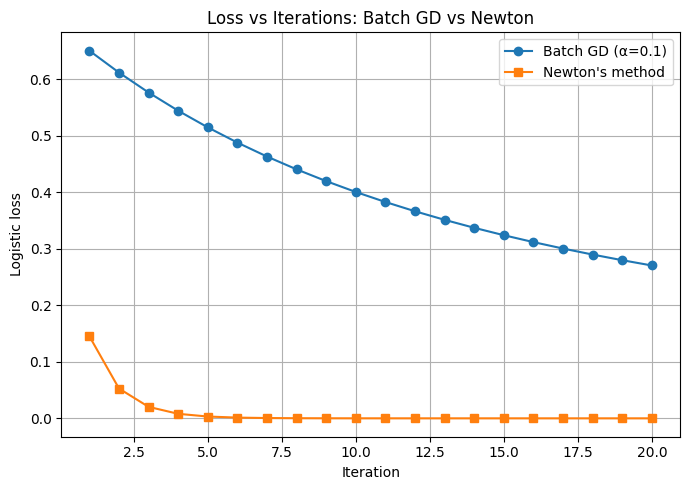

Saved figure: loss_compare.png


In [6]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_loss(w):
    p = sigmoid(Xb @ w)
    eps = 1e-12
    return -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))

# Batch GD history

def batch_gd_history(alpha=0.1, iters=20):
    w = np.zeros(D + 1)
    losses = []
    for t in range(iters):
        p = sigmoid(Xb @ w)
        grad = (Xb.T @ (p - y)) / N
        w -= alpha * grad
        losses.append(logistic_loss(w))
    return np.array(losses), w

# Newton history

def newton_history(iters=20, damping=1e-6):
    w = np.zeros(D + 1)
    losses = []
    for t in range(iters):
        z = Xb @ w
        p = sigmoid(z)
        g = (Xb.T @ (p - y)) / N                       # gradient
        s = p * (1 - p)                                 # (N,)
        XS = Xb * s[:, None]
        H = (Xb.T @ XS) / N + damping * np.eye(D + 1)   # damped Hessian
        delta = np.linalg.solve(H, g)                   # Newton step
        w -= delta
        losses.append(logistic_loss(w))
    return np.array(losses), w

# compute histories
gd_losses, w_gd = batch_gd_history(alpha=0.1, iters=20)
newton_losses, w_newton = newton_history(iters=20, damping=1e-6)

# Plot

plt.figure(figsize=(7,5))
plt.plot(range(1, 21), gd_losses, marker='o', label='Batch GD (α=0.1)')
plt.plot(range(1, 21), newton_losses, marker='s', label="Newton's method")
plt.xlabel('Iteration')
plt.ylabel('Logistic loss')
plt.title('Loss vs Iterations: Batch GD vs Newton')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_compare.png', dpi=200)
plt.show()

print("Saved figure: loss_compare.png")

Batch GD for the new centers [[2, 2], [5, 1.5]], with loss/accuracy tracking

iter  1: loss=0.6769, acc=0.9325
iter  5: loss=0.6193, acc=0.9330
iter 10: loss=0.5611, acc=0.9330
iter 20: loss=0.4773, acc=0.9340


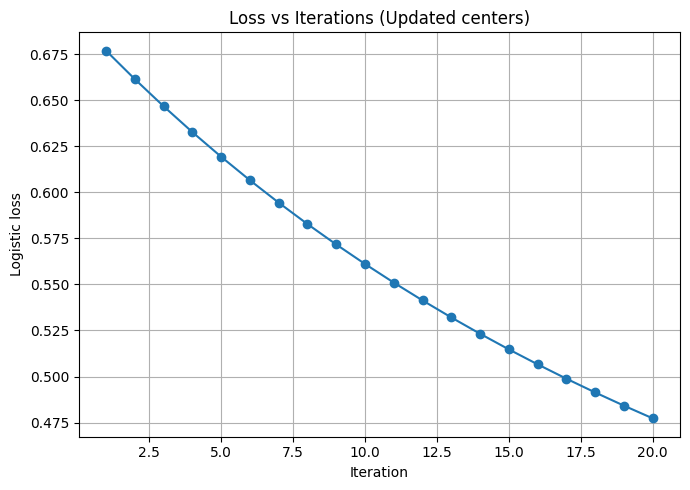

Saved figure: loss_updated_centers.png


In [ ]:
# Batch GD on updated centers = [[2, 2], [5, 1.5]]
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Data (updated centers)
np.random.seed(0)
centers = [[2, 2], [5, 1.5]]
X, y = make_blobs(n_samples=2000, centers=centers, random_state=5)
X = np.dot(X, np.array([[0.5, 0.5], [-0.5, 1.5]]))  # same transformation as listing 3

# Standardize for better conditioning (strongly recommended for GD)
X = StandardScaler().fit_transform(X)

# Add bias column
N, D = X.shape
Xb = np.hstack([np.ones((N, 1)), X])  # (N, D+1)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_loss(w):
    p = sigmoid(Xb @ w)
    eps = 1e-12
    return -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))

def accuracy(w):
    p = sigmoid(Xb @ w)
    yhat = (p >= 0.5).astype(int)
    return (yhat == y).mean()

# Batch GD (20 iterations as in earlier parts)
alpha = 0.1    
T = 20

w = np.zeros(D + 1)
loss_hist, acc_hist = [], []

for t in range(1, T + 1):
    p = sigmoid(Xb @ w)                 # (N,)
    grad = (Xb.T @ (p - y)) / N         # (D+1,)
    w = w - alpha * grad

    loss_hist.append(logistic_loss(w))
    acc_hist.append(accuracy(w))

    if t in (1, 5, 10, 20):
        print(f"iter {t:2d}: loss={loss_hist[-1]:.4f}, acc={acc_hist[-1]:.4f}")

# Plot loss curve for the report
plt.figure(figsize=(7,5))
plt.plot(range(1, T + 1), loss_hist, marker='o', label='Batch GD (updated centers)')
plt.xlabel('Iteration')
plt.ylabel('Logistic loss')
plt.title('Loss vs Iterations (Updated centers)')
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_updated_centers.png', dpi=200)
plt.show()

print("Saved figure: loss_updated_centers.png")


Because the two clusters are closer and typically more overlapping than before, the problem is less separable.

The GD loss still decreases, but will often plateau at a higher value than with well-separated centers; test/train accuracy will also saturate below 100% (some inevitable misclassifications).

If you see small oscillations or very slow decrease, lower the step size (e.g., alpha=0.05). Feature standardization (used above) is important to stabilize and speed up GD